In [1]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
from livelossplot import PlotLosses
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data

# define constants
N_SAMPLES=16000*4
SAMPLE_RATE=16000
SEED=1

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)



# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))


In [23]:
BATCH_SIZE=10
    
USE_NSYNTH=False
if USE_NSYNTH:
    
    class CustomNSynthTfds(ddsp.training.data.TfdsProvider):
      """Parses features in the TFDS NSynth dataset.
      Unlike the default Nsynth data provider, this class keeps the the nsynth instrument metadata.

      If running on Cloud, it is recommended you set `data_dir` to
      'gs://tfds-data/datasets' to avoid unnecessary downloads.
      """

      def __init__(self,
                   name='nsynth/gansynth_subset.f0_and_loudness:2.3.3',
                   split='train',
                   data_dir='gs://tfds-data/datasets',
                   sample_rate=16000,
                   frame_rate=250,
                   include_note_labels=True):
        """TfdsProvider constructor.
        Args:
          name: TFDS dataset name (with optional config and version).
          split: Dataset split to use of the TFDS dataset.
          data_dir: The directory to read the prepared NSynth dataset from. Defaults
            to the public TFDS GCS bucket.
          sample_rate: Sample rate of audio in the dataset.
          frame_rate: Frame rate of features in the dataset.
          include_note_labels: Return dataset without note-level labels
            (pitch, instrument).
        """
        self._include_note_labels = include_note_labels

        super().__init__(name, split, data_dir, sample_rate, frame_rate)

      def get_dataset(self, shuffle=True):
        """Returns dataset with slight restructuring of feature dictionary."""
        def preprocess_ex(ex):
          ex_out = {
              'audio':
                  ex['audio'],
              'f0_hz':
                  ex['f0']['hz'],
              'f0_confidence':
                  ex['f0']['confidence'],
              'loudness_db':
                  ex['loudness']['db'],
          }
          if self._include_note_labels:
            ex_out.update({
                'pitch':
                    ex['pitch'],
                'velocity':
                    ex['velocity'],
                'instrument_source':
                    ex['instrument']['source'],
                'instrument_family':
                    ex['instrument']['family'],
                'instrument':
                    ex['instrument']['label'],
            })
          return ex_out

        dataset = super().get_dataset(shuffle)
        dataset = dataset.map(preprocess_ex, num_parallel_calls=_AUTOTUNE)
        return dataset

    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="train", try_gcs=False,download=True) 
    trn_data_provider = CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="train")

    tfds.load("nsynth/gansynth_subset.f0_and_loudness",split="valid", try_gcs=False,download=True) 
    val_data_provider = CustomNSynthTfds(data_dir="/root/tensorflow_datasets/",split="valid")
    
    # take a batch of flute sounds
    #dataset = data_provider.get_dataset()

    # take only acoustic sounds
    #dataset=dataset.filter(lambda x: x["instrument_source"]==0)

    # take only flute sounds
    #dataset=dataset.filter(lambda x: x["instrument_family"]==2)

    # flutes
    # 2965 samples
    # 36 instruments
    # 5 velocities 
    # 61 pitches

    #test_batch=next(iter(dataset.batch(4))) 

    #play(tf.reshape(test_batch["audio"],(-1)))

    # TODO: CLEAN UP DATASET. REMOVE WHERE CREPE IS UNCERTAIN.

    def crepe_is_certain(x):
        is_playing = tf.cast(x["loudness_db"]>-100.0,dtype=tf.float32)
        average_certainty=tf.reduce_sum(x["f0_confidence"]*is_playing)/tf.reduce_sum(is_playing)
        return average_certainty

    '''
    for s in range(1):

        print("###")

        sample = next(iter(dataset))
        play(sample["audio"])

        print(crepe_is_certain(sample))

        plt.plot(sample["loudness_db"])
        plt.show()

        plt.plot(sample["f0_hz"])
        plt.show()

        plt.plot(sample["f0_confidence"])
        plt.show()

    '''

    INSTRUMENT_FAMILY=2

    def preprocess_dataset(dataset):
        if INSTRUMENT_FAMILY!="all":
            dataset=dataset.filter(lambda x: x["instrument_family"]==INSTRUMENT_FAMILY)
        return dataset


    trn_dataset = preprocess_dataset(trn_data_provider.get_dataset())
    val_dataset = preprocess_dataset(val_data_provider.get_dataset())

    # take only flute sounds

    batched_trn_dataset= trn_dataset.shuffle(10000).batch(BATCH_SIZE)

else:
    INSTRUMENT_FAMILY="solos-violin-clean"
    
    trn_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/trn/*")
    val_data_provider=data.MultiTFRecordProvider(f"datasets/{INSTRUMENT_FAMILY}/tfr/val/*")
    
    trn_dataset= trn_data_provider.get_dataset()
    val_dataset=val_data_provider.get_dataset()
    
    print(f"{len(list(trn_dataset))} examples pre filtering")
    
    trn_dataset=trn_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    val_dataset=val_dataset.filter(lambda x: tf.math.count_nonzero(x["audio"])>0)
    
    # limit to one instrument
    #first_instrument_id = next(iter(trn_dataset))["instrument"]
    #trn_dataset=trn_dataset.filter(lambda x: x["instrument"]==first_instrument_id)
    
    print(f"{len(list(trn_dataset))} examples post filtering")
    
    
    batched_trn_dataset=trn_dataset.shuffle(10000).batch(BATCH_SIZE,drop_remainder=True)

16632 examples pre filtering
12224 examples post filtering


In [27]:
# define model

N_NOISE_MAGNITUDES=64
N_HARMONICS=64


class CustomReverb(ddsp.processors.Processor):

    def __init__(self,name='reverb'):
        """Takes neural network outputs directly as the impulse response.
        Args:
          trainable: Learn the impulse_response as a single variable for the entire
            dataset.
          reverb_length: Length of the impulse response. Only used if
            trainable=True.
          add_dry: Add dry signal to reverberated signal on output.
          name: Name of processor module.
        """
        super().__init__(name=name)
    
    def get_controls(self, audio, ir=None):
        """Convert decoder outputs into ir response.
        Args:
          audio: Dry audio. 2-D Tensor of shape [batch, n_samples].
          ir: 3-D Tensor of shape [batch, ir_size, 1] or 2D Tensor of shape
            [batch, ir_size].
        Returns:
          controls: Dictionary of effect controls.
        """
        return {'audio': audio, 'ir': ir}

    def get_signal(self, audio, ir):
        """Apply impulse response.
        Args:
          audio: Dry audio, 2-D Tensor of shape [batch, n_samples].
          ir: 3-D Tensor of shape [batch, ir_size, 1] or 2D Tensor of shape
            [batch, ir_size].
        Returns:
          tensor of shape [batch, n_samples]
        """
        wet = ddsp.core.fft_convolve(audio, ir, padding='same', delay_compensation=0)
        return wet

    
    
preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

decoder = ddsp.training.decoders.RnnFcDecoder(
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled', 'z'),
               output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),)

harmonic_synth = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

filtered_noise = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-3.0, name='noise')
reverb = ddsp.effects.Reverb(name="reverb",trainable=False)
add = ddsp.processors.Add(name='add')

dag = [
  (harmonic_synth, ['amps', 'harmonic_distribution', 'f0_hz']),
  (filtered_noise, ['magnitudes']),
  (add, ['harmonic/signal', 'noise/signal']),
  (reverb, ["add/signal","ir"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                              mag_weight=1.0,
                                              logmag_weight=1.0)

class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               z_size=None,
               ir_size=None,
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        self.n_instruments=n_instruments
        self.instrument_z = tf.Variable(tf.random.normal([n_instruments,1,z_size]))
        self.instrument_ir = tf.Variable(tf.concat([tf.ones([n_instruments,1]),tf.zeros([n_instruments,ir_size-1])],axis=-1))
        self.instrument_id2idx={}
        
    def call(self, batch, training=True):
        n_timesteps=batch["f0_hz"].shape[1]
        instrument_idxs=[]
        for sample_index in range(batch["instrument"].shape[0]):
          instrument_id=batch["instrument"][sample_index].numpy()
          if instrument_id not in self.instrument_id2idx:
              self.instrument_id2idx[instrument_id]=len(self.instrument_id2idx.keys())
          instrument_idxs.append(self.instrument_id2idx[instrument_id])
        with tf.GradientTape() as tape:
          batch["z"]=tf.tile(tf.tanh(tf.gather(self.instrument_z,instrument_idxs)),[1,n_timesteps,1])
          batch["ir"]=tf.tanh(tf.gather(self.instrument_ir,instrument_idxs))     
        return super().call(batch,training=False)

In [28]:
Z_SIZE=512

N_INSTRUMENTS=1050

IR_SIZE=int(SAMPLE_RATE*1.0)

plotlosses = PlotLosses()

ae = MultiInstrumentAutoencoder(preprocessor=preprocessor,decoder=decoder,processor_group=processor_group,n_instruments=N_INSTRUMENTS,z_size=Z_SIZE,ir_size=IR_SIZE) 


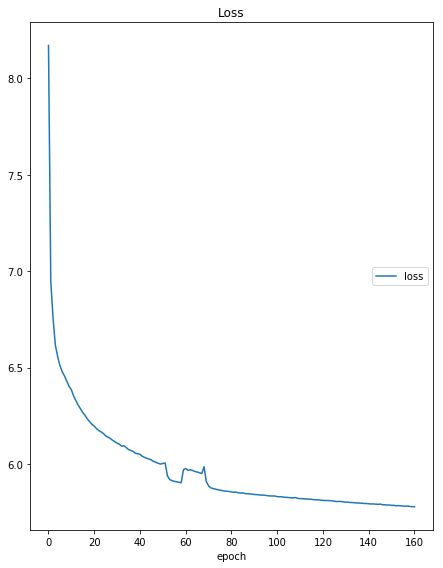

Loss
	loss             	 (min:    5.779, max:    8.171, cur:    5.779)
summary nr: 20


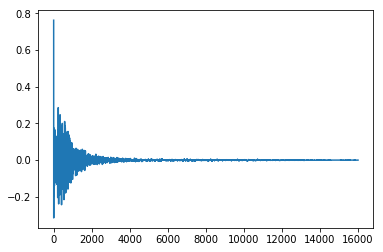

batch nr 0, loss: 6.053448677062988


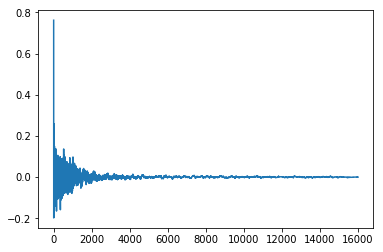

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


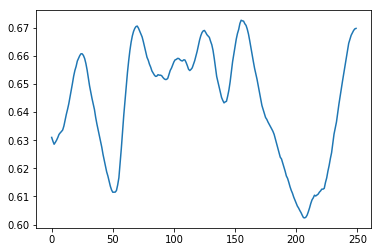

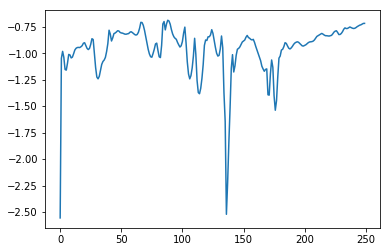

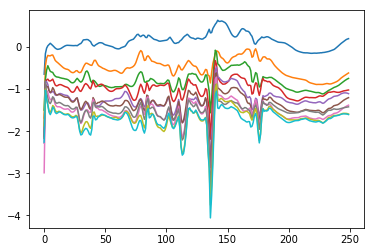

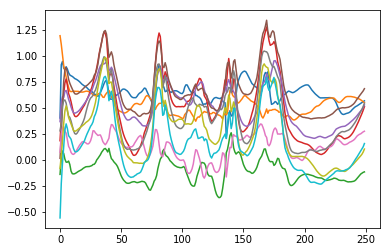

batch nr 10, loss: 5.745069980621338


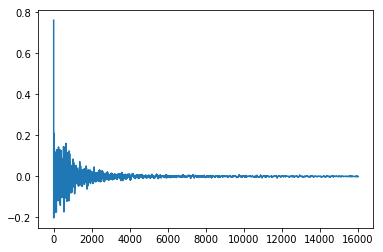

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


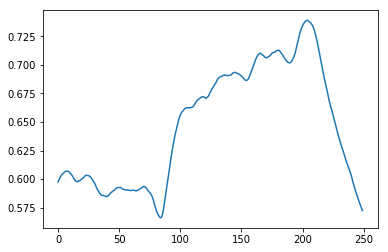

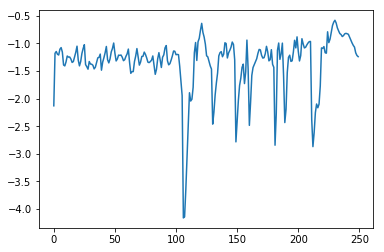

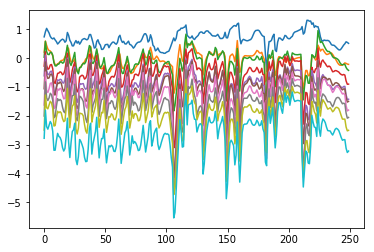

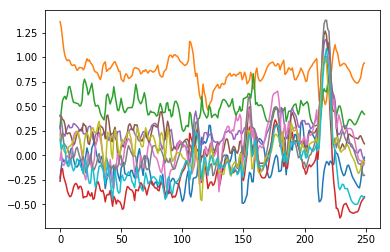

batch nr 20, loss: 5.072196006774902


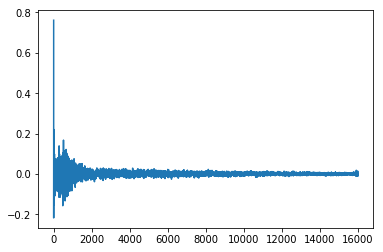

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


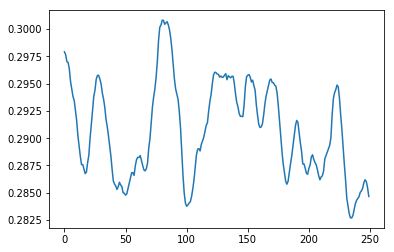

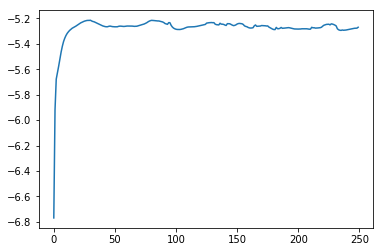

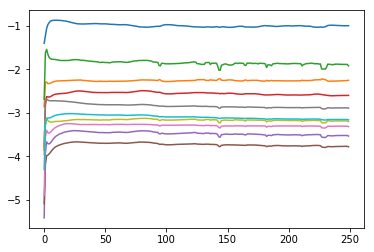

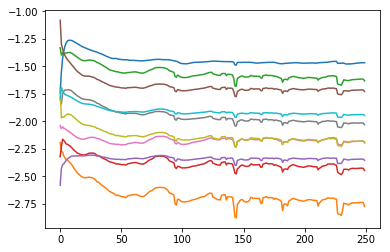

batch nr 30, loss: 5.651942729949951


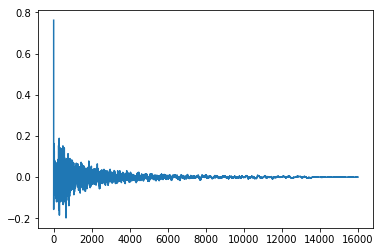

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


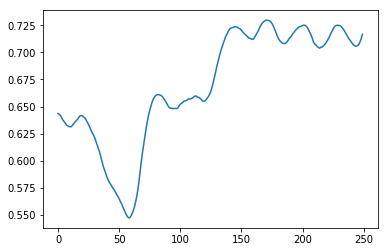

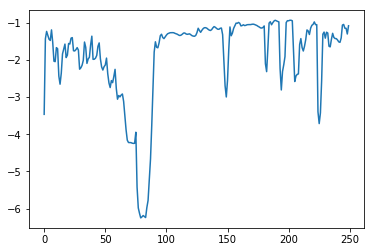

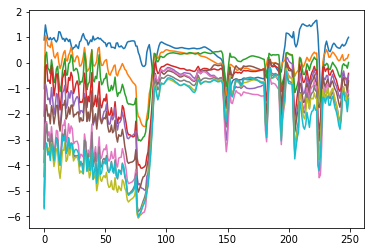

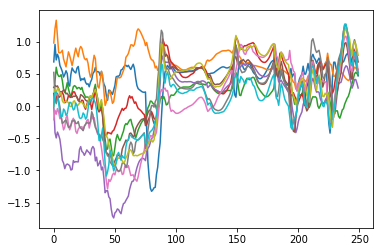

batch nr 40, loss: 6.089792728424072


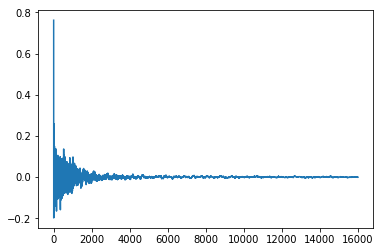

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


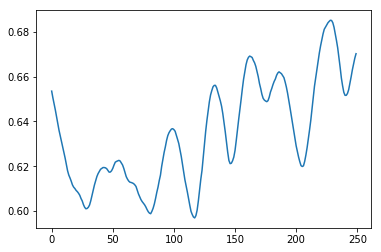

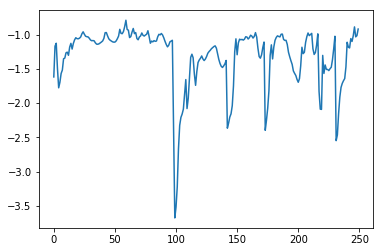

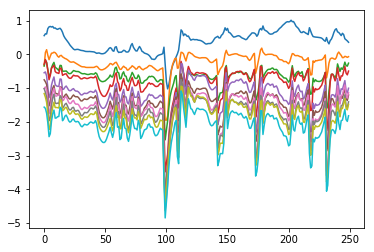

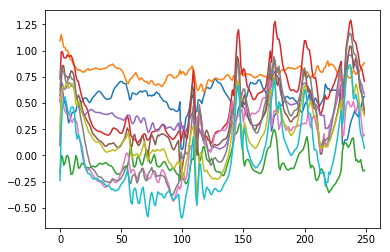

batch nr 50, loss: 5.931263446807861


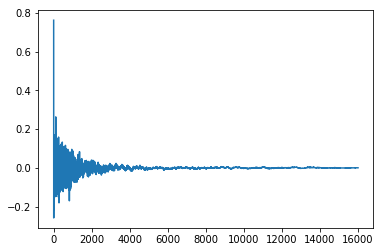

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


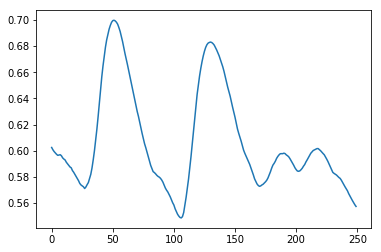

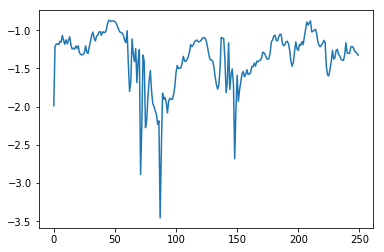

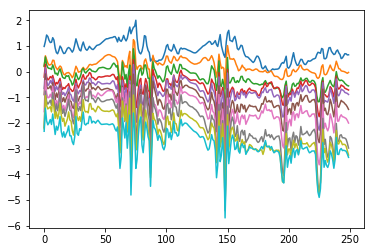

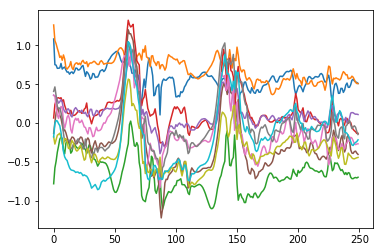

batch nr 60, loss: 5.807064533233643


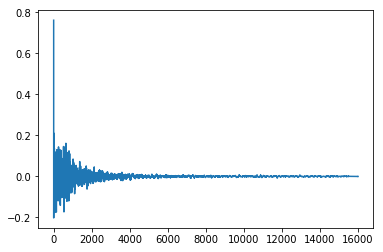

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


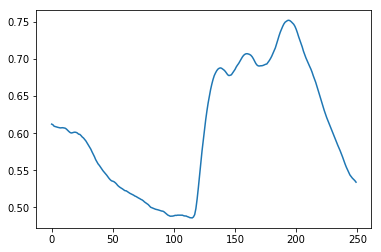

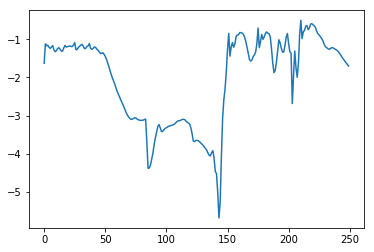

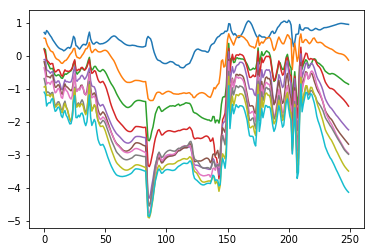

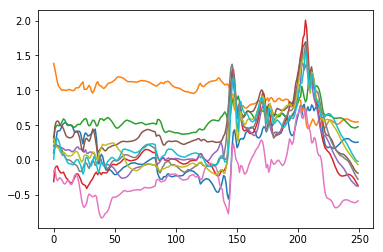

batch nr 70, loss: 5.9448394775390625


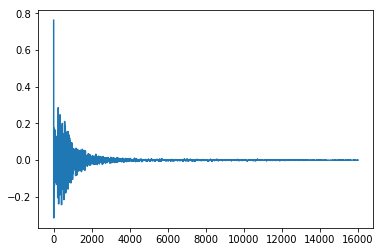

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


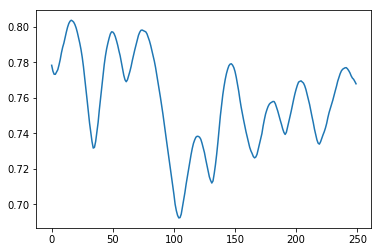

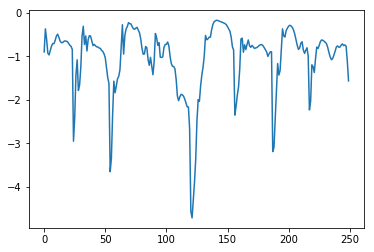

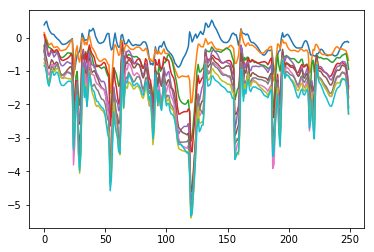

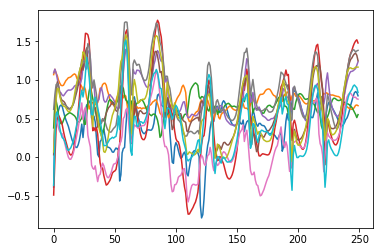

batch nr 80, loss: 5.561760902404785


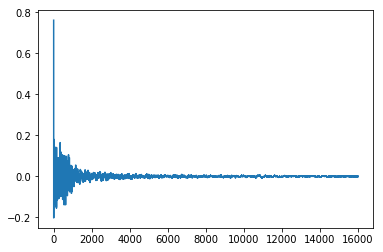

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


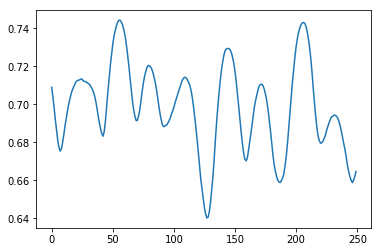

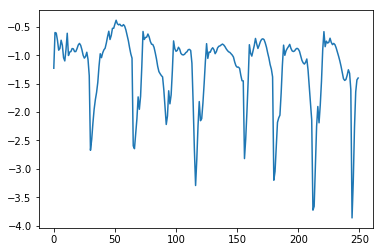

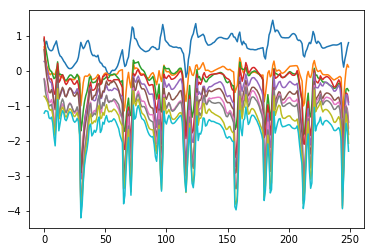

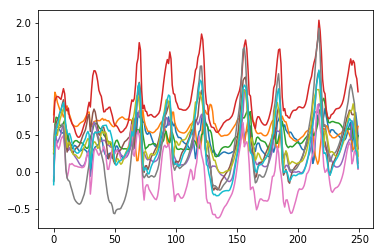

batch nr 90, loss: 6.051060676574707


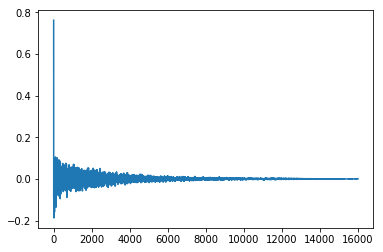

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'instrument', 'z', 'ir', 'f0_scaled', 'ld_scaled', 'amps', 'harmonic_distribution', 'magnitudes', 'harmonic', 'noise', 'add', 'reverb', 'out', 'audio_synth'])


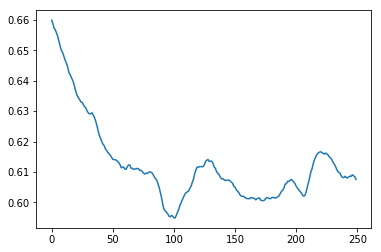

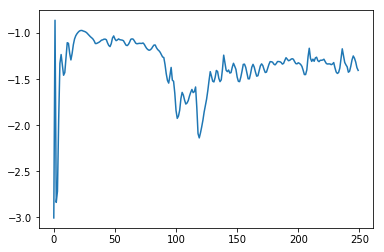

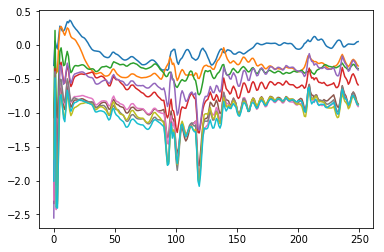

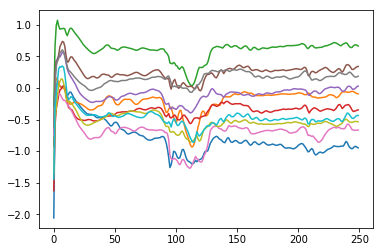

In [ ]:
## training loop with adam

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


checkpoint_path=f"artefacts/ae_checkpoint_family_{INSTRUMENT_FAMILY}"
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass
e=0

while True:
  batch_counter=0
  epoch_loss=0   
  for batch in batched_trn_dataset:
    
    with tf.GradientTape() as tape:
    
        a = time.time()

        output=ae(batch,training=False)

        loss_value=spectral_loss(batch["audio"],output['audio_synth'])

        gradients = tape.gradient(loss_value, [*ae.trainable_variables])

        epoch_loss+=loss_value.numpy()

        optimizer.apply_gradients(zip(gradients, [*ae.trainable_variables]))


        if batch_counter % 10==0:
            print(f"batch nr {batch_counter}, loss: {loss_value.numpy()}")
            plt.plot(output["ir"][0])
            plt.show()
            
            print(output.keys())
            
            plt.plot(output["ld_scaled"][0,:250])
            plt.show()
            plt.plot(output["amps"][0,:250])
            plt.show()
            plt.plot(output["harmonic_distribution"][0,:250,:10])
            plt.show()
            plt.plot(output["magnitudes"][0,:250,:10])
            plt.show()

        batch_counter+=1
  
  plotlosses.update({'loss': epoch_loss/batch_counter,})

  plotlosses.send()

  print(f"summary nr: {e}")


  play(tf.reshape(output["audio"],(-1)))
  play(tf.reshape(output['audio_synth'],(-1)))
  play(tf.reshape(output['add']["signal"],(-1))) 
    
  plt.plot(output["ir"][0])
  plt.show()
    
  ae.save_weights(checkpoint_path)

  e+=1




In [43]:
import pydash

import random
## validation 

print("v")

val_dataset=list(val_dataset)

VAL_LR=1e-3

# group by instrument id
val_dataset_by_instrument=pydash.collections.group_by(list(val_dataset),lambda x: str(x["instrument"].numpy()))

fit_iterations=1000

def rf2cf(row_form):
    return {k:[s[k] for s in row_form] for k in row_form[0].keys()}
    
DEMO_NOTE_SAMPLES=int(4.0*SAMPLE_RATE)

N_FIT=4

val_dataset_by_instrument = {k:v for k,v in val_dataset_by_instrument.items() if len(v)>N_FIT*2}

for instrument_set in val_dataset_by_instrument.values(): 
    
    random.shuffle(instrument_set)
    
    instrument_set = instrument_set[:min(16,len(instrument_set))]

    val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)

    # fit an embedding to highest and lowest note
    
    #fit_data=[instrument_set[int(len(instrument_set)/2)]]
    
    fit_data=instrument_set[:N_FIT]
    
    demo_data=instrument_set[N_FIT:N_FIT*2]
    
    N_FIT_SAMPLES=len(fit_data)
    
    #convert to column form
    fit_data = rf2cf(fit_data)
        
    fit_batch= next(iter(tf.data.Dataset.from_tensor_slices(fit_data).batch(N_FIT_SAMPLES)))
    
    fit_z=tf.Variable(tf.random.normal([1,INSTRUMENT_EMBEDDING_SIZE]))
    fit_ir=tf.Variable(tf.concat([tf.zeros([1,1]),tf.zeros([1,IR_SIZE-1])],axis=-1))
    
    for i in range(fit_iterations):
     
        with tf.GradientTape() as tape:
          fit_batch["z"]=tf.tile(tf.tanh(fit_z),[N_FIT_SAMPLES,1])
          fit_batch["ir"]=tf.tile(tf.tanh(fit_ir),[N_FIT_SAMPLES,1])
            
          output=ae(fit_batch,training=False)

          loss_value=spectral_loss(fit_batch["audio"],output['audio_synth'])

          gradients = tape.gradient(loss_value, [fit_z,fit_ir])
          gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
            
          if i % 10 == 0:
              print(loss_value)
        
        val_optimizer.apply_gradients(zip(gradients, [fit_z,fit_ir]))
        
    print(loss_value)
           
    play(tf.reshape(fit_batch["audio"],(-1)))
    play(tf.reshape(output['audio_synth'],(-1)))
    play(tf.reshape(output['add']["signal"],(-1)))
    play(tf.reshape(fit_ir,(-1)))
        
    N_SCALE_SAMPLES=len(demo_data)
        
    scale_data = rf2cf(demo_data) 
    scale_batch= next(iter(tf.data.Dataset.from_tensor_slices(scale_data).batch(N_SCALE_SAMPLES)))
    
    play(tf.reshape(scale_batch["audio"][:,:DEMO_NOTE_SAMPLES],(-1)))
    
    scale_batch["z"] = tf.tile(tf.tanh(fit_z),[N_SCALE_SAMPLES,1])
    scale_batch["ir"] = tf.tile(fit_ir,[N_SCALE_SAMPLES,1])
        
    scale_batch_output=ae(scale_batch,training=False)
    
    play(tf.reshape(scale_batch_output['audio_synth'][:,:DEMO_NOTE_SAMPLES],(-1)))

v


NameError: name 'INSTRUMENT_EMBEDDING_SIZE' is not defined

# 